In [1]:
import numpy as np
import IPython.display as ipd
from joblib import Parallel, delayed

## Datasets

| Datasets        | #images           | #labels  | #images per label (minimum)|
| --------------- |:-----------------:| :-------:|---------------------------:|
| fgvc-aircraft-2013b | 10000 | 100 | 100 |
| birdSnap    | 49829 | 500 | 69 (100 for most species)  |

To avoid unbalanced number of labels per task, we use only a small proportion (100*100 samples) of BirdSnaps.

In [2]:
n_task_aircraft = 5 # divide aircraft into 5 tasks
n_task_birdsnap = 5 # for birdsnap, select 100 species that contains 100 samples and divide these 100 into 5 tasks 
n_task = 10

n_label_per_task = 20
n_sample_label = 90 # limited by birdsnap
test_size=0.4 # 54 train, 36 test

In [3]:
path_aircraft_x_all = 'F:/Programming/Python/NDD/Dataset_Preprocessing/data/aircraft_x_all.npy'
path_aircraft_y_all = 'F:/Programming/Python/NDD/Dataset_Preprocessing/data/aircraft_y_all.npy'

path_birdsnap_x_all = 'F:/Programming/Python/NDD/Dataset_Preprocessing/data/birdsnap_x_all.npy'
path_birdsnap_y_all = 'F:/Programming/Python/NDD/Dataset_Preprocessing/data/birdsnap_y_all.npy'

In [4]:
from numpy import load

aircraft_x_all = np.load(path_aircraft_x_all)
aircraft_y_all = np.load(path_aircraft_y_all)

birdsnap_x_all = np.load(path_birdsnap_x_all)
birdsnap_y_all = np.load(path_birdsnap_y_all)

In [5]:
aircraft_x_all[aircraft_y_all == 1][:90].shape

(90, 32, 32, 3)

In [6]:
from sklearn.model_selection import train_test_split

train_x_task = [[], [], [], [], [], [], [], [], [], []]
test_x_task = [[], [], [], [], [], [], [], [], [], []]
train_y_task = [[], [], [], [], [], [], [], [], [], []]
test_y_task = [[], [], [], [], [], [], [], [], [], []]

# load aircraft data to tasks
for i in range(n_task_aircraft):
    X = np.empty([0,32,32,3])
    Y = np.empty([0,])
    for j in range(n_label_per_task):
        new_x = aircraft_x_all[aircraft_y_all == n_label_per_task*i + j + 1][:90]
        new_y = aircraft_y_all[aircraft_y_all == n_label_per_task*i + j + 1][:90]
        X = np.concatenate((X, new_x), axis=0)
        Y = np.concatenate((Y, new_y), axis=0)
    train_x_task[i], test_x_task[i], train_y_task[i], test_y_task[i] = train_test_split(X, Y,test_size=test_size)
    

In [7]:
train_x_task[0].shape

(1080, 32, 32, 3)

In [8]:
# load birdsnap data to tasks
for i in range(n_task_birdsnap):
    X = np.empty([0,32,32,3])
    Y = np.empty([0,])
    for j in range(n_label_per_task):
        new_x = birdsnap_x_all[birdsnap_y_all == n_label_per_task*i + j + 1][:90]
        new_y = birdsnap_y_all[birdsnap_y_all == n_label_per_task*i + j + 1][:90] + 100 #should I add 100 to distinguish between birdsnap and aircraft?
        X = np.concatenate((X, new_x), axis=0)
        Y = np.concatenate((Y, new_y), axis=0)
    train_x_task[n_task_aircraft+i], test_x_task[n_task_aircraft+i], train_y_task[n_task_aircraft+i], test_y_task[n_task_aircraft+i] = train_test_split(X, Y,test_size=test_size)

In [9]:
train_y_task[9].shape

(1080,)

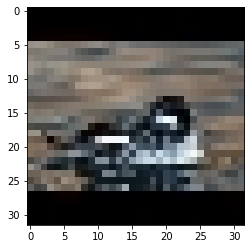

In [10]:
import matplotlib.pyplot as plt

# task 1-5 is aircraft, 6-10 is birdsnap
img = train_x_task[5][0]
plt.imshow(img.astype(np.uint8))

In [ ]:
from flying_functions import single_experiment

# L2N Model

model = 'uf'
ntrees = 10     # number of trees, used when model is uf
num_repetition = 5

accuracy_list = Parallel(n_jobs=5)(delayed(single_experiment)(train_x_task,test_x_task,train_y_task,test_y_task,ntrees,model) for _ in range(num_repetition))

accuracy_all_avg = np.average(accuracy_list, axis = 0)

In [ ]:
accuracy_all_avg

In [ ]:
from flying_functions import calculate_results

err, bte, fte, te = calculate_results(accuracy_all_avg)

In [ ]:
# L2F vs L2N, without shuffle
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

num_tasks = 10
sns.set(style='ticks')

fontsize = 30
ticksize = 24
markersize = 16
linewidth = 3

fig, ax = plt.subplots(2, 2, figsize=(20, 14.5))

# FTE
ax[0][0].plot(np.arange(1, num_tasks + 1), fte, c='red', marker='.', markersize=markersize, linewidth=linewidth, label = 'Odif')
ax[0][0].hlines(1, 1, num_tasks, colors='grey', linestyles='dashed', linewidth=0.5*linewidth)
ax[0][0].tick_params(labelsize=ticksize)
ax[0][0].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[0][0].set_ylabel('Forward TE',fontsize=fontsize)

# BTE
for i in range(num_tasks):
    et = np.asarray(bte[i])
    ns = np.arange(i + 1, num_tasks + 1)
    ax[0][1].plot(ns, et, c='red', linewidth=linewidth)

ax[0][1].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[0][1].set_ylabel('Backward TE', fontsize=fontsize)
ax[0][1].tick_params(labelsize=ticksize)
ax[0][1].hlines(1, 1, num_tasks, colors='grey', linestyles='dashed', linewidth=0.5*linewidth)

# TE
for i in range(num_tasks):
    et = np.asarray(te[i])
    ns = np.arange(i + 1, num_tasks + 1)
    ax[1][0].plot(ns, et, c='red', linewidth=linewidth)

ax[1][0].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[1][0].set_ylabel('Transfer Efficiency', fontsize=fontsize)
ax[1][0].tick_params(labelsize=ticksize)
ax[1][0].hlines(1, 1, num_tasks, colors='grey', linestyles='dashed', linewidth=0.5*linewidth)
ax[1][0].yaxis.set_major_locator(MultipleLocator(1))

# Accuracy
for i in range(num_tasks):
    et = 1 - np.asarray(err[i])
    ns = np.arange(i + 1, num_tasks + 1)
    if i == 0: ax[1][1].plot(ns, et, c='red', linewidth=linewidth, label = 'Odif')
    else: ax[1][1].plot(ns, et, c='red', linewidth=linewidth)

ax[1][1].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[1][1].set_ylabel('Accuracy', fontsize=fontsize)
ax[1][1].tick_params(labelsize=ticksize)
